In [2]:
import torch
import numpy as np
import torch.nn as nn
import pandas as pd
from psmiles import PolymerSmiles as PS
from torch.utils.data import DataLoader, Dataset, random_split
from rdkit import Chem
from rdkit.Chem import Draw
from PIL import Image
from scipy.sparse import csr_matrix, lil_matrix
import atomInSmiles
from collections import Counter
from IPython.display import clear_output, display
import ipywidgets as widgets
from tqdm.notebook import tqdm
import os
import sys
import matplotlib.pyplot as plt
from matplotlib.ticker import LogFormatter, LogLocator, LogFormatterMathtext
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device=torch.device('cpu')
print(device)
# os.chdir("C:\\Users\\user\\test.venv")
# print(os.getcwd())
from sklearn.preprocessing import MinMaxScaler, FunctionTransformer
from sklearn.pipeline import Pipeline

log_transformer = FunctionTransformer(np.log1p, validate=True)
log_minmax_pipeline = Pipeline(steps=[
    ('log', log_transformer),
    ('minmax', MinMaxScaler())
])

cuda


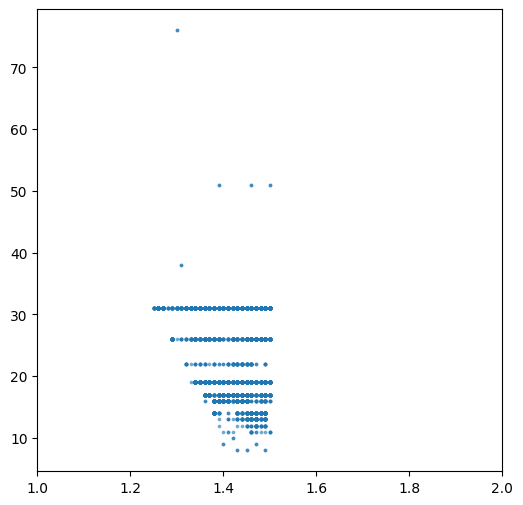

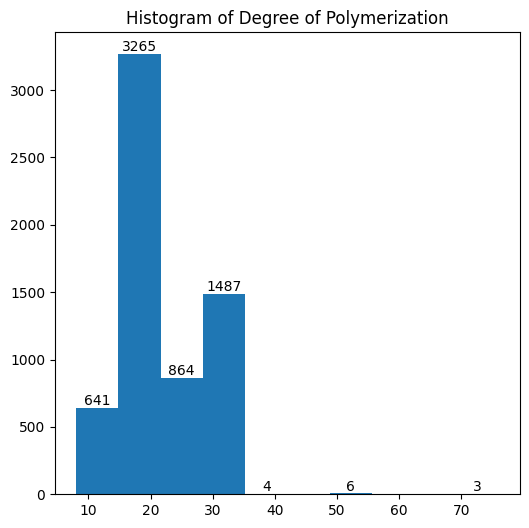

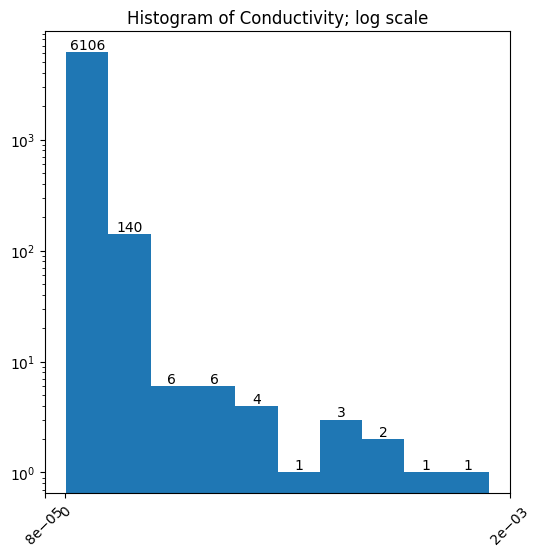

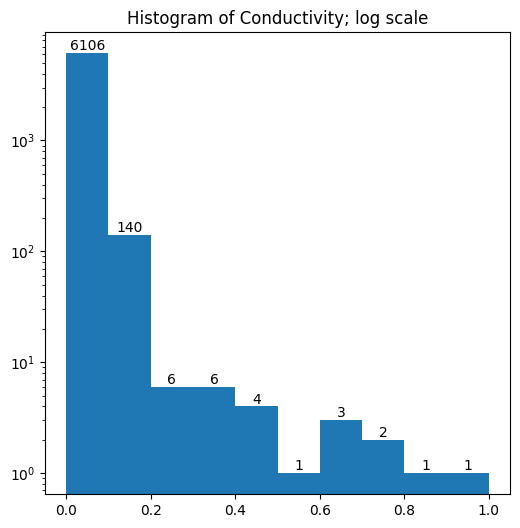

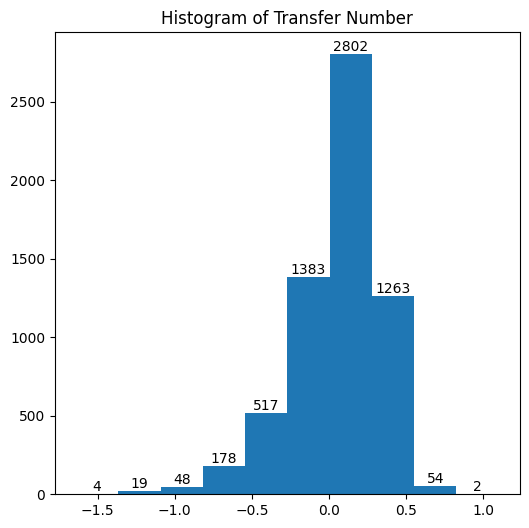

In [3]:
test_dd = pd.read_csv("simulation-trajectory-aggregate.csv")
molal = test_dd.iloc[:, 2:3].values
dp = test_dd.iloc[:, 4:5].values
con = test_dd.iloc[:, 6:7].values
tnn = test_dd.iloc[:, 10:11].values

#DP scatter plot
plt.figure(figsize=(6, 6))
plt.scatter(molal, dp, s=3, alpha=0.5)
plt.xlim([1.0, 2.0])

#DP histogram
plt.figure(figsize=(6,6))
counts, bins, patches = plt.hist(dp, bins=10)
plt.title("Histogram of Degree of Polymerization")

for count, x in zip(counts, bins):
    if count == 0:
        continue
    plt.text(x + (bins[1] - bins[0]) / 2, count,    # x 좌표는 막대의 가운데
             str(int(count)),                      # 정수로 변환한 count
             ha='center', va='bottom')             # 가운데 정렬
plt.show()

#Li+ Conductivity hitogram
plt.figure(figsize=(6,6))
counts, bins, patches = plt.hist(con)
plt.yscale('log')
plt.xscale('symlog')
ax = plt.gca()
ax.xaxis.set_major_formatter(LogFormatter())
plt.xticks(rotation=45)  # 라벨 회전
plt.title("Histogram of Conductivity; log scale")
for count, x in zip(counts, bins):
    plt.text(x + (bins[1] - bins[0]) / 2, count,    # x 좌표는 막대의 가운데
             str(int(count)),                      # 정수로 변환한 count
             ha='center', va='bottom')             # 가운데 정렬
plt.show()

con_log = log_minmax_pipeline.fit_transform(con.reshape(-1, 1))
#Li+ Conductivity hitogram
plt.figure(figsize=(6,6))
counts, bins, patches = plt.hist(con_log)
plt.yscale('log')
plt.title("Histogram of Conductivity; log scale")
for count, x in zip(counts, bins):
    plt.text(x + (bins[1] - bins[0]) / 2, count,    # x 좌표는 막대의 가운데
             str(int(count)),                      # 정수로 변환한 count
             ha='center', va='bottom')             # 가운데 정렬
plt.show()


#Li+ Transfer Number histogram
plt.figure(figsize=(6,6))
counts, bins, patches = plt.hist(tnn, bins=10)
for count, x in zip(counts, bins):
    if count == 0:
        continue
    plt.text(x + (bins[1] - bins[0]) / 2, count,    # x 좌표는 막대의 가운데
             str(int(count)),                      # 정수로 변환한 count
             ha='center', va='bottom')             # 가운데 정렬
plt.title("Histogram of Transfer Number")
plt.show()

In [4]:
mm_scaler = MinMaxScaler()
class load_data(Dataset):
    def __init__(self, path):
        #csv 읽기
        self.raw = pd.read_csv(path)

        #SMILES
        self.SMILES = self.raw.iloc[:, 1:2].values
        self.SMILES = np.squeeze(self.SMILES)

        #Li-ion Conductivity
        self.conductivity = self.raw.iloc[:, 6:7].values
        self.conductivity = log_minmax_pipeline.fit_transform(self.conductivity.reshape(-1, 1))

        #Degree of Polymerization
        self.DP = self.raw.iloc[:, 4:5].values
        self.DP = mm_scaler.fit_transform(self.DP.reshape(-1, 1))

        #Transfer Number
        self.tn = self.raw.iloc[:, 10:11].values
        self.tn1 = self.tn
        self.tn = mm_scaler.fit_transform(self.tn.reshape(-1, 1))

        self.properties = np.concat((self.conductivity, self.DP, self.tn), axis=-1)

        #PSMILES 변환
        psmiles = []
        for smiles in self.SMILES:
            ps = PS(smiles)
            ps.canonicalize
            psmiles.append(ps.psmiles)

        #Atom-In-SMILES Encoding
        ais_encoding = []
        for smiles in psmiles:
            ais_encoding.append(atomInSmiles.encode(smiles))
        

        #Atom-In-SMILES Tokenization (Encoder)
        ais_tokens = []
        for smiles in ais_encoding:
            ais_tokens.append(atomInSmiles.smiles_tokenizer("[SOS] " + smiles +" [EOS]"))

        max_len = len(max(ais_encoding, key=len)) + 1
        self.max_len = max_len
        print("max sequence length : ", max_len)

        #vocab 구성
        corpus = []
        for frags in ais_tokens:
            corpus.extend(frags)
        corpus.append("[PAD]")
        token_count = Counter(corpus)
        vocab = { token:i for i, (token, count) in enumerate(sorted(token_count.items(), key=lambda x: x[1], reverse=True))}
        vocab_size = len(vocab)
        
        self.vocab = vocab

        num_data = len(ais_tokens)
        print(vocab)

        ais_tokens_enc = ais_tokens
        ais_tokens_enc = [[tok for tok in tokens if tok not in ['[SOS]', '[EOS]']] for tokens in ais_tokens_enc]

        ais_tokens_dec_input = ais_tokens
        ais_tokens_dec_input = [[tok for tok in tokens if tok not in ['[EOS]']] for tokens in ais_tokens_dec_input]

        ais_tokens_dec_output = ais_tokens
        ais_tokens_dec_output = [[tok for tok in tokens if tok not in ['[SOS]']] for tokens in ais_tokens_dec_output]

        #Tokens to number (encoder)
        ais_token_num_enc = torch.full((num_data, max_len),166, dtype=torch.long)
        i=0
        for tokens in ais_tokens_enc:
            for length in range((len(tokens))):
                ais_token_num_enc[i, length] = vocab[tokens[length]]
            i += 1

        #Tokens to number (Decoder Input)
        ais_token_num_dec_input = torch.full((num_data, max_len),166, dtype=torch.long)
        i=0
        for tokens in ais_tokens_dec_input:
            for length in range((len(tokens))):
                ais_token_num_dec_input[i, length] = vocab[tokens[length]]
            i += 1

        #Tokens to number (Decoder Output)
        ais_token_num_dec_output = torch.full((num_data, max_len),166, dtype=torch.long)
        i=0
        for tokens in ais_tokens_dec_output:
            for length in range((len(tokens))):
                ais_token_num_dec_output[i, length] = vocab[tokens[length]]
            i += 1

        self.SMILES_enc = ais_token_num_enc
        self.SMILES_dec_input = ais_token_num_dec_input
        self.SMILES_dec_output = ais_token_num_dec_output

        vocab_size, num_data
        print("vocab size : ", vocab_size,"\nnumber of data : ",num_data)
        self.num_data = num_data
        
        self.vocab = vocab
        self.vocab_size = vocab_size


        print(self.SMILES_enc.shape)
        self.properties = torch.tensor(self.properties, dtype=torch.float).unsqueeze(-1)
        print(self.properties.shape)

        self.test_data = self.SMILES_enc[50]

        print("PSMILES : ", psmiles[50])
        print("After AIS encoding : ", ais_encoding[50])
        print("After AIS Tokenization : ", ais_tokens_enc[50])
        print("After to number : ", ais_token_num_enc[50])
    
    def __getitem__(self, i):
        return self.SMILES_enc[i], self.SMILES_dec_input[i], self.SMILES_dec_output[i], self.properties[i]
    
    def __len__(self):
        return self.SMILES_enc.shape[0]
    
    def vocab_len(self):
        return self.vocab_size

In [5]:

Polymers = "simulation-trajectory-aggregate.csv"
dataset = load_data(Polymers)

generator = torch.Generator().manual_seed(42)
train_dataset, val_dataset = random_split(dataset, [0.75, 0.25], generator=generator)

train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True, drop_last=False)
val_dataloader = DataLoader(val_dataset, batch_size=256, shuffle=False, drop_last=False)

max sequence length :  265
{'(': 0, ')': 1, '=': 2, '[O;!R;C]': 3, '[CH3;!R;C]': 4, '[CH2;!R;CN]': 5, '[CH2;!R;CC]': 6, '[CH2;!R;CO]': 7, '[*;!R;C]': 8, '[SOS]': 9, '[EOS]': 10, '[O;!R;CC]': 11, '[NH;!R;CC]': 12, '[*;!R;O]': 13, '[O;!R;*C]': 14, '[C;!R;*OO]': 15, '[CH;!R;CCO]': 16, '[CH;!R;CCN]': 17, '[C;!R;CNO]': 18, '[N;!R;CCC]': 19, '[C;!R;*NO]': 20, '[*;!R;N]': 21, '[NH;!R;*C]': 22, '[CH3;!R;N]': 23, '[CH;!R;CCC]': 24, '[C;!R;CCCO]': 25, '[CH;!R;CC]': 26, '[F;!R;C]': 27, '[CH2;!R;C]': 28, '[C;!R;COO]': 29, '[CH3;!R;O]': 30, '[C;!R;CCCN]': 31, '#': 32, '[C;!R;CCCC]': 33, '[CH2;!R;CS]': 34, '[C;!R;CC]': 35, '[OH;!R;C]': 36, '[S;!R;CC]': 37, '[N;!R;C]': 38, '[C;!R;CN]': 39, '[CH;!R;C]': 40, '[C;!R;CCC]': 41, '[NH2;!R;C]': 42, '[CH;!R;CFF]': 43, '[O;!R;S]': 44, '[O;!R;CN]': 45, '[CH;!R;CCS]': 46, '[CH2;!R;CF]': 47, '[CH3;!R;S]': 48, '[C;!R;CCO]': 49, '[NH;!R;CO]': 50, '[C;!R;NNO]': 51, '[CH2;!R;*C]': 52, '[C;!R;CFFF]': 53, '[C;!R;CCFF]': 54, '[C;!R;NOO]': 55, '[C;!R;OOO]': 56, '[S;!R;C

In [6]:
import math
#from torch_pca import PCA
from torch.nn import TransformerDecoder, TransformerDecoderLayer, TransformerEncoder, TransformerEncoderLayer

class LayerNorm(nn.Module):
    def __init__(self, d_model, eps=1e-12):
        super(LayerNorm, self).__init__()
        self.gamma = nn.Parameter(torch.ones(d_model))
        self.beta = nn.Parameter(torch.zeros(d_model))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        var = x.var(-1, unbiased=False, keepdim=True)

        out = (x - mean) / torch.sqrt(var + self.eps)
        out = self.gamma * out + self.beta
        return out

class PositionalEncoding(torch.nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = torch.nn.Dropout(p=dropout)
        self.d_model = d_model
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        pos_embedding =  self.pe[:, :x.size(1), :]
        pos_embedding = torch.repeat_interleave(pos_embedding, x.shape[0], dim=0)
        x =  torch.cat([x, pos_embedding], dim=2)
        return self.dropout(x)

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model=64, nhead=4):
        super(MultiHeadAttention, self).__init__()
        self.multihead_attn = nn.MultiheadAttention(d_model, nhead, batch_first=True)

    def forward(self, query, key, value, attn_mask=None):
        attn_output, _ = self.multihead_attn(query, key, value, attn_mask=attn_mask)
        return attn_output


class TFEncoder(nn.Module):
    def __init__(self, d_model=256, n_heads=4, d_ff=64, enc_seq_len=5000, dropout=0.2):
        super().__init__()
        self.normLayer = LayerNorm(d_model=d_model)
        
        self.encoderLayer = TransformerEncoderLayer(batch_first=True,
                                               d_model=d_model,
                                               nhead=n_heads,
                                               dim_feedforward=d_ff,
                                               dropout=dropout,
                                               activation="gelu")
        self.encoder = TransformerEncoder(encoder_layer=self.encoderLayer, num_layers=2,
                                          norm=self.normLayer)
        self.input_embedding_smiles = nn.Embedding(dataset.vocab_size, d_model // 2)
        self.pos_encoding = PositionalEncoding(d_model // 2, dropout, max_len=enc_seq_len)


    def forward(self, smiles_enc, properties):
        smiles_enc = self.input_embedding_smiles(smiles_enc)
        cat = torch.cat((smiles_enc, properties), dim=1)
        enc_input_0 = self.pos_encoding(cat)

        encoded_0 = self.encoder(enc_input_0)

        return encoded_0

class TFDecoder(nn.Module):
    def __init__(self, d_model=256, n_heads=4, d_ff=64, enc_seq_len=5000, dropout=0.2):
        super().__init__()
        self.normLayer = LayerNorm(d_model=d_model)
        self.decoderLayer = TransformerDecoderLayer(batch_first=True,
                                               d_model=d_model,
                                               nhead=n_heads,
                                               dim_feedforward=d_ff,
                                               dropout=dropout,
                                               activation="gelu")
        self.decoder = TransformerDecoder(decoder_layer=self.decoderLayer,num_layers=1,
                                          norm=self.normLayer)

        self.input_embedding_smiles = nn.Embedding(dataset.vocab_size, d_model // 2)
        self.pos_encoding = PositionalEncoding(d_model // 2, dropout, max_len=enc_seq_len)

    def generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask
    
    def forward(self, dec_input, latent):
        dec_input = self.input_embedding_smiles(dec_input)
        dec_input_0 = self.pos_encoding(dec_input)
        x_mask = self.generate_square_subsequent_mask(dec_input.shape[1]).to(device)
        memory_mask = self.generate_square_subsequent_mask(latent.shape[1]).to(device)

        decoded = self.decoder(dec_input_0, latent, tgt_mask=x_mask, memory_mask = memory_mask)
        return decoded

class PDecoder(nn.Module):
    def __init__(self, d_model=64, n_heads=4, d_ff=32, enc_seq_len=3, dropout=0.2):
        super().__init__()
        self.normLayer = LayerNorm(d_model=d_model)
        
        self.decoderLayer = TransformerDecoderLayer(batch_first=True,
                                               d_model=d_model,
                                               nhead=n_heads,
                                               dim_feedforward=d_ff,
                                               dropout=dropout,
                                               activation="gelu")
        self.decoder = TransformerDecoder(decoder_layer=self.decoderLayer,num_layers=2)

        self.predict = nn.Linear(d_model, 1)

    def generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask
    def forward(self, dec_input, latent):
        x_mask = self.generate_square_subsequent_mask(dec_input.shape[1]).to(device)

        decoded = self.decoder(dec_input, latent, tgt_mask=x_mask)
        tgt = self.predict(decoded)

        return tgt


In [7]:
class CVAE(nn.Module):
    def __init__(self, d_model=256, latent_dim = 64):
        super().__init__()
        self.conv = nn.Conv1d(in_channels=268, out_channels=265, kernel_size=1)
        self.to_means = nn.Linear(d_model, latent_dim)
        self.to_var = nn.Linear(d_model, latent_dim)

        self.encoder = TFEncoder()
        self.decoder = TFDecoder()
        self.pdecoder = PDecoder()

        self.crossattn = MultiHeadAttention()

        self.predict = nn.Linear(d_model, dataset.vocab_size)

        self.input_embedding_p = nn.Sequential(
            nn.Linear(1, d_model // 2),
            nn.GELU(),
            nn.Linear(d_model // 2, d_model // 8),
        )

        self.input_embedding = nn.Sequential(
            nn.Linear(1, d_model // 8),
            nn.GELU(),
            nn.Linear(d_model // 8, d_model // 4),
            nn.GELU(),
            nn.Linear(d_model // 4, d_model // 2),
        )
        self.ff = nn.Sequential(
            nn.Linear(d_model//4, 32),
            nn.GELU(),
            nn.Linear(32, d_model//4),
            nn.GELU(),
            nn.Linear(d_model // 4, d_model)
        )

        self.pos_enc = PositionalEncoding(d_model // 8, dropout=0.2, max_len=5000)

        self.softmax = nn.Softmax(dim=-1)
    
    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var).to(device)
        eps = torch.rand_like(std).to(device)
        return mu + eps * std

    def forward(self, smiles_enc, smiles_dec_input, properties):
        properties_e = self.input_embedding(properties)
        properties_p = self.input_embedding_p(properties)

        encoded = self.encoder(smiles_enc, properties_e) # (batch_size, seq_len, d_model // 8) 
        encoded = self.conv(encoded)

        means = self.to_means(encoded).permute(0, 2, 1)
        log_var = self.to_var(encoded).permute(0, 2, 1)

        z = self.reparameterize(means, log_var).permute(0, 2, 1)

        properties_p = self.pos_enc(properties_p)

        z_z = self.crossattn(z, properties_p, properties_p)
        z_z = self.ff(z_z)

        output = self.decoder(smiles_dec_input, z_z)
        tgt = self.pdecoder(properties_p, z)

        output = self.predict(output)



        return output, tgt, means, log_var, z
    

In [8]:
import torch.nn.functional as F
class VAELoss(nn.Module):
    """
    Enhanced VAE loss with KL collapse mitigation:
      - Cyclic or linear KL annealing
      - Optional Free Bits threshold
      - Capacity control (β-VAE style)
      - Property MSE loss

    Args:
        vocab_size (int): Number of classes for token reconstruction.
        max_beta (float): Maximum KL weight.
        anneal_steps (int): Steps to reach max_beta (for linear annealing).
        cycle_length (int): Length of cycle for cyclic annealing (if use_cyclic=True).
        use_cyclic (bool): Toggle cyclic annealing; else linear.
        free_bits (float): Threshold τ for free bits (per dim).
        capacity (float): Target KL capacity C; if >0, applies capacity control.
        gamma (float): Weight for capacity loss when capacity>0.
        property_loss_weight (float): Weight for MSE property loss.
    """
    def __init__(
        self,
        vocab_size: int,
        max_beta: float = 1.0,
        anneal_steps: int = 100,
        cycle_length: int = 50,
        use_cyclic: bool = False,
        free_bits: float = 0.0,
        capacity: float = 0.0,
        gamma: float = 100.0,
        property_loss_weight: float = 1.0
    ):
        super().__init__()
        self.vocab_size = vocab_size
        self.max_beta = max_beta
        self.anneal_steps = anneal_steps
        self.cycle_length = cycle_length
        self.use_cyclic = use_cyclic
        self.free_bits = free_bits
        self.capacity = capacity
        self.gamma = gamma
        self.property_loss_weight = property_loss_weight

    def forward(
        self,
        output: torch.Tensor,
        input_tokens: torch.Tensor,
        mean: torch.Tensor,
        log_var: torch.Tensor,
        tgt: torch.Tensor,
        properties: torch.Tensor,
        step: int
    ) -> torch.Tensor:
        # Reconstruction loss (mean per sample)
        batch_size = output.size(0)
        logits = output.view(batch_size, -1, self.vocab_size)
        # Use sum over seq and mean over batch
        recon_loss = F.cross_entropy(
            logits.view(-1, self.vocab_size),
            input_tokens.view(-1),
            reduction='sum'
        ) / batch_size

        # Property regression loss
        mse_loss = F.mse_loss(properties, tgt)

        # KL divergence per example (sum over dims)
        kld_elements = -0.5 * (1 + log_var - mean.pow(2) - log_var.exp())
        # shape: [batch, latent_dim]
        kld_per_dim = kld_elements.sum(dim=0) if self.free_bits > 0 else None
        kld = kld_elements.sum(dim=1)  # shape: [batch]
        kld_mean = kld.mean()

        # Free Bits: apply threshold per dimension
        if self.free_bits > 0:
            # clamp kld per dim then reconstruct kld sum
            kld_fb = torch.clamp(kld_per_dim / mean.size(1) - self.free_bits, min=0) * mean.size(1)
            kld = kld_fb.sum() / batch_size
        else:
            kld = kld_mean

        # Annealing weight beta
        if self.use_cyclic:
            cycle_pos = (step % self.cycle_length) / self.cycle_length
            beta = cycle_pos * self.max_beta
        else:
            beta = min(self.max_beta, self.max_beta * step / self.anneal_steps)

        # Capacity control or weighted KL
        if self.capacity > 0:
            # difference from target capacity
            kl_term = self.gamma * torch.abs(kld - self.capacity)
        else:
            kl_term = beta * kld

        # Total loss
        loss = (recon_loss + kl_term) + self.property_loss_weight * mse_loss
        return loss, recon_loss, kld_mean

In [9]:
def reverse_one_hot_encoding(one_hot_tensor, vocab):
    # 인덱스 → 토큰 매핑 생성
    index_to_token = {idx: token for token, idx in vocab.items()}

    # 복원된 토큰 시퀀스를 저장할 리스트
    original_tokens_list = []

    # GPU 텐서면 CPU로
    if one_hot_tensor.is_cuda:
        one_hot_tensor = one_hot_tensor.cpu()

    # one-hot → argmax (인덱스 시퀀스)
    try:
        _ = one_hot_tensor.shape[1]
        one_hot_tensor = torch.argmax(one_hot_tensor, dim=-1)
    except:
        pass  # 이미 1D 라면 그대로 둠

    # “값이 166인” 위치만 추출
    idx_166 = torch.nonzero(one_hot_tensor == 166, as_tuple=True)[0]

    # 만약 166 토큰이 하나도 없으면 전체 길이 사용
    end_pos = idx_166[0].item() if len(idx_166) > 0 else one_hot_tensor.size(0)

    # 0부터 end_pos 직전까지 토큰 복원
    for i in range(end_pos):
        token_idx = one_hot_tensor[i].item()
        original_tokens_list.append(index_to_token.get(token_idx, "<UNK>"))

    return original_tokens_list
print(dataset.test_data)
test = reverse_one_hot_encoding(dataset.test_data, dataset.vocab)
print(test)
print(atomInSmiles.decode(' '.join(test)))
#print(dataset.vocab)


tensor([ 13,  14,  16,   0,   4,   1,   6,   6,   5,  12,  18,   0,   2,   3,
          1,  16,   0,   4,   1,  11,  15,   0,   8,   1,   2,   3, 166, 166,
        166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166,
        166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166,
        166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166,
        166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166,
        166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166,
        166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166,
        166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166,
        166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166,
        166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166,
        166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166,
        166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 1

In [ ]:
model = CVAE()
model.cuda()
lr = 3e-5
optim = torch.optim.AdamW(model.parameters(), lr=lr)
loss_fn = VAELoss(
    vocab_size=dataset.vocab_size,
    max_beta=0.5,          # KL penalty 강하게
    anneal_steps=100,
    use_cyclic=False,
    free_bits=0.1,
    capacity=0.0,          # per‑dim 0.1 목표
    gamma=5.0,
    property_loss_weight=2.0
)


In [11]:
from torchinfo import summary
smiles = torch.ones([128, dataset.max_len], dtype=torch.long).to(device)
pp = torch.ones([128, 3, 1], dtype=torch.float).to(device)
summary(model, input_data=(smiles, smiles, pp))

Layer (type:depth-idx)                             Output Shape              Param #
CVAE                                               [128, 265, 167]           --
├─Sequential: 1-1                                  [128, 3, 128]             --
│    └─Linear: 2-1                                 [128, 3, 32]              64
│    └─GELU: 2-2                                   [128, 3, 32]              --
│    └─Linear: 2-3                                 [128, 3, 64]              2,112
│    └─GELU: 2-4                                   [128, 3, 64]              --
│    └─Linear: 2-5                                 [128, 3, 128]             8,320
├─Sequential: 1-2                                  [128, 3, 32]              --
│    └─Linear: 2-6                                 [128, 3, 128]             256
│    └─GELU: 2-7                                   [128, 3, 128]             --
│    └─Linear: 2-8                                 [128, 3, 32]              4,128
├─TFEncoder: 1-3         

In [ ]:
import datetime
status_out = widgets.Output()
display(status_out)
kld = []
bce = []
epoch = 3600
model.train()
progress = tqdm(range(epoch), desc="Training")

loss_arr = list()
real = list()
predict = list()
for i in progress:
    batchloss = 0.0
    bce_mean = 0
    kld_mean = 0
    t=0
    for (smiles_enc, smiles_dec_input, smiles_dec_output, properties) in train_dataloader:
        optim.zero_grad()

        smiles_enc = smiles_enc.to(device)
        smiles_dec_input = smiles_dec_input.to(device)
        smiles_dec_output = smiles_dec_output.to(device)
        properties = properties.to(device)


        # smiles_dec_input = model.softmax(smiles_dec_input)
        #smiles_dec_output = model.softmax(smiles_dec_output)

        result, tgt, means, log_var, z = model(smiles_enc, smiles_dec_input, properties)
        
        loss, BCE, KLD = loss_fn(result.float(), smiles_dec_output, means, log_var, tgt, properties.float(), i)
        loss.backward()
        optim.step()
        batchloss += loss
        bce_mean += BCE.item()
        kld_mean += KLD.item()
        t+=1
    bce.append(bce_mean/ (265*t))
    kld.append(kld_mean/t)
    
    loss = batchloss.cpu().item() / len(train_dataloader)
    loss_arr.append(loss)
    
    #progress.set_description("loss: {:0.6f}".format(loss))


    # argmax_indices = torch.argmax(result, dim=-1)
    # output = torch.nn.functional.one_hot(argmax_indices, num_classes=result.size(-1))

    original_tokens = reverse_one_hot_encoding(smiles_dec_output[50], dataset.vocab)
    predicted_tokens = reverse_one_hot_encoding(result[50], dataset.vocab)

    original_str = atomInSmiles.decode(' '.join(original_tokens))
    predicted_str = atomInSmiles.decode(' '.join(predicted_tokens))


    # 진행 바의 속성으로부터 필요한 값들 추출 (예시)
    elapsed = int(progress.format_dict.get("elapsed", 0))
    formatted_elap = str(datetime.timedelta(seconds=elapsed))
    rate = progress.format_dict.get("rate", None)
    sec_per_iter = 1 / rate if rate and rate != 0 else 0
    total = int(sec_per_iter * 1200)
    formatted_total = str(datetime.timedelta(seconds=total))
    
    # 고정된 2줄 상태 정보를 업데이트 (Output 위젯에 출력)
    with status_out:
        clear_output(wait=True)
        print(f"🔹 Elapsed: {formatted_elap} | sec/iter: {sec_per_iter:.3f}s")
        print("🔹 Total time: ", formatted_total)
        print(f"🔹 Step: {i+1}/{progress.total}")
        print("🔹 loss: {:0.6f}".format(loss))
        print("BCE : ", bce[-1],
              "KLD : ", kld[-1],
              "MSE : ", F.mse_loss(properties, tgt).item())
        print(f"[Epoch {i}] Original : {original_str}")
        print(f"[Epoch {i}] Predict  : {predicted_str}")
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))
        axs[0].plot(loss_arr, label="loss")
        axs[0].set_yscale('log', base = 10)
        axs[0].set_title("Total Loss")

        axs[1].plot(bce)
        axs[1].set_title("BCE")
        axs[1].set_yscale('log', base = 10)

        axs[2].plot(kld)
        axs[2].set_title("KLD")
        axs[2].set_yscale('log', base = 10)
        plt.tight_layout()
        plt.show()


Output()

Training:   0%|          | 0/3600 [00:00<?, ?it/s]

In [ ]:
model.eval()
results = []
origin = []

properties_results=[]
properties_origin=[]
print(len(val_dataset))
with torch.no_grad():
    for (smiles_enc, smiles_dec_input, smiles_dec_output, properties) in val_dataloader:

        smiles_enc = smiles_enc.to(device)
        smiles_dec_input = smiles_dec_input.to(device)
        smiles_dec_output = smiles_dec_output.to(device)
        properties = properties.to(device)

        result, tgt, means, log_var, z = model(smiles_enc, smiles_dec_input, properties)


        results.append(result)
        origin.append(smiles_dec_output)

        properties_results.append(tgt)
        properties_origin.append(properties)

results = torch.cat(results, dim=0)
origin = torch.cat(origin, dim=0)
results = nn.functional.softmax(results, dim=-1) 
argmax_indices = torch.argmax(results, dim=-1)
output = torch.nn.functional.one_hot(argmax_indices, num_classes=results.size(-1))

print(results.shape)
print(origin.shape)

from sklearn.metrics import mean_absolute_error
properties_origin=torch.cat(properties_origin,dim=0)
properties_results=torch.cat(properties_results,dim=0)
MAE_2 = mean_absolute_error(properties_origin.squeeze().cpu(), properties_results.squeeze().cpu())
print("MAE(properties) : ", MAE_2)


results_smiles = []
origin_smiles = []
for i in range(results.shape[0]):
    results_smiles.append(atomInSmiles.decode(' '.join(reverse_one_hot_encoding(results[i], dataset.vocab))))
    origin_smiles.append(atomInSmiles.decode(' '.join(reverse_one_hot_encoding(origin[i], dataset.vocab))))


1567
torch.Size([1567, 265, 167])
torch.Size([1567, 265])
MAE(properties) :  0.013977184102820402


In [ ]:
origin_smiles = [smiles.removesuffix("EOS").strip() for smiles in origin_smiles]
results_smiles = [smiles.removesuffix("EOS").strip() for smiles in results_smiles]


for i in range(len(results_smiles)):
    if(origin_smiles[i] != results_smiles[i]):
        print(i, "번째 다름!")
    print("real smiles      : ", origin_smiles[i])
    print("predicted smiles : ", results_smiles[i])


MAE = mean_absolute_error(origin.cpu(), torch.argmax(results.cpu(), dim=-1))
print("MAE : ", MAE)



real smiles      :  *OC(CC)CNC(C=C)COC(*)=O
predicted smiles :  *OC(CC)CNC(C=C)COC(*)=O
real smiles      :  *NCC(C)(CC)C(C)OC(*)=O
predicted smiles :  *NCC(C)(CC)C(C)OC(*)=O
real smiles      :  *OCCCOC(=O)CC(CCC)OC(*)=O
predicted smiles :  *OCCCOC(=O)CC(CCC)OC(*)=O
real smiles      :  *OCC(C)(CNC(=O)C=CC)COC(*)=O
predicted smiles :  *OCC(C)(CNC(=O)C=CC)COC(*)=O
real smiles      :  *OCCN(CCC)C(=O)C(C)OC(*)=O
predicted smiles :  *OCCN(CCC)C(=O)C(C)OC(*)=O
real smiles      :  *OC(C)CN(N)CC(C)OC(*)=O
predicted smiles :  *OC(C)CN(N)CC(C)OC(*)=O
real smiles      :  *OC(CNC(=O)C(F)F)COC(*)=O
predicted smiles :  *OC(CNC(=O)C(F)F)COC(*)=O
real smiles      :  *NCCCN(C)CCC(NC(*)=O)C(C)C
predicted smiles :  *NCCCN(C)CCC(NC(*)=O)C(C)C
real smiles      :  *OCC(C)(C)CNCC(CC)OC(*)=O
predicted smiles :  *OCC(C)(C)CNCC(CC)OC(*)=O
real smiles      :  *OC(C)C(COC(*)=O)NC(=O)C(F)CC
predicted smiles :  *OC(C)C(COC(*)=O)NC(=O)C(F)CC
real smiles      :  *OCCN(C)CC(COCC#C)OC(*)=O
predicted smiles :  *OCCN(C)CC

In [ ]:
from rdkit import Chem, RDLogger
from rdkit.Chem import DataStructs, rdFingerprintGenerator
RDLogger.DisableLog('rdApp.error')

generator = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=2048)
def tanimoto_similarity(smiles1, smiles2):
    mol1 = Chem.MolFromSmiles(smiles1)
    mol2 = Chem.MolFromSmiles(smiles2)
    fp1 = generator.GetFingerprint(mol1)
    fp2 = generator.GetFingerprint(mol2)
    return DataStructs.TanimotoSimilarity(fp1, fp2)

def is_valid(smiles):
    return Chem.MolFromSmiles(smiles) is not None



TS = 0
canbe = 0
notbe = 0


for i in range(len(results_smiles)):

    if is_valid(results_smiles[i]):
        raw = tanimoto_similarity(results_smiles[i], origin_smiles[i])
        canbe += 1
    else:
        notbe += 1
    TS += raw
PS.fingerprint
print("Tanimoto Similarity : ", TS / canbe)
print("가능한 분자 개수 : ", canbe)
print("불가능한 분자 개수 :", notbe)
print(canbe / len(results_smiles))

Tanimoto Similarity :  1.0179362044745086
가능한 분자 개수 :  1525
불가능한 분자 개수 : 42
0.97319719208679


In [ ]:
for name, param in model.named_parameters():
    print(f"Layer: {name}, shape: {param.shape}")

state = model.state_dict()

# state 딕셔너리의 키 확인 (해당 키 이름은 named_parameters()와 동일)
print(state.keys())

# # conv1 레이어의 weight 추출
# conv1_weight = state['conv1.weight']
# print("conv1 weight shape from state_dict:", conv1_weight.shape)


Layer: conv.weight, shape: torch.Size([265, 268, 1])
Layer: conv.bias, shape: torch.Size([265])
Layer: to_means.weight, shape: torch.Size([64, 256])
Layer: to_means.bias, shape: torch.Size([64])
Layer: to_var.weight, shape: torch.Size([64, 256])
Layer: to_var.bias, shape: torch.Size([64])
Layer: encoder.normLayer.gamma, shape: torch.Size([256])
Layer: encoder.normLayer.beta, shape: torch.Size([256])
Layer: encoder.encoderLayer.self_attn.in_proj_weight, shape: torch.Size([768, 256])
Layer: encoder.encoderLayer.self_attn.in_proj_bias, shape: torch.Size([768])
Layer: encoder.encoderLayer.self_attn.out_proj.weight, shape: torch.Size([256, 256])
Layer: encoder.encoderLayer.self_attn.out_proj.bias, shape: torch.Size([256])
Layer: encoder.encoderLayer.linear1.weight, shape: torch.Size([64, 256])
Layer: encoder.encoderLayer.linear1.bias, shape: torch.Size([64])
Layer: encoder.encoderLayer.linear2.weight, shape: torch.Size([256, 64])
Layer: encoder.encoderLayer.linear2.bias, shape: torch.Size([

In [ ]:
save_path = "model_weights_dmodel256.pth"
torch.save(model.state_dict(), save_path)

In [ ]:
save_path = "model_weights_dmodel256.pth"
state_dict = torch.load(save_path)
model.load_state_dict(state_dict)

FileNotFoundError: [Errno 2] No such file or directory: 'model_weights_dmodel256.pth'

In [ ]:
tn_data = load_data("simulation-trajectory-aggregate_aligned.csv")

tn = DataLoader(tn_data, batch_size=128, shuffle=False, drop_last=False)



max sequence length :  265
{'(': 0, ')': 1, '=': 2, '[O;!R;C]': 3, '[CH3;!R;C]': 4, '[CH2;!R;CN]': 5, '[CH2;!R;CC]': 6, '[CH2;!R;CO]': 7, '[*;!R;C]': 8, '[SOS]': 9, '[EOS]': 10, '[O;!R;CC]': 11, '[NH;!R;CC]': 12, '[*;!R;O]': 13, '[O;!R;*C]': 14, '[C;!R;*OO]': 15, '[CH;!R;CCO]': 16, '[CH;!R;CCN]': 17, '[C;!R;CNO]': 18, '[N;!R;CCC]': 19, '[C;!R;*NO]': 20, '[*;!R;N]': 21, '[NH;!R;*C]': 22, '[CH3;!R;N]': 23, '[CH;!R;CCC]': 24, '[C;!R;CCCO]': 25, '[CH;!R;CC]': 26, '[F;!R;C]': 27, '[CH2;!R;C]': 28, '[C;!R;COO]': 29, '[CH3;!R;O]': 30, '[C;!R;CCCN]': 31, '#': 32, '[C;!R;CCCC]': 33, '[CH2;!R;CS]': 34, '[C;!R;CC]': 35, '[OH;!R;C]': 36, '[S;!R;CC]': 37, '[N;!R;C]': 38, '[C;!R;CN]': 39, '[CH;!R;C]': 40, '[C;!R;CCC]': 41, '[NH2;!R;C]': 42, '[CH;!R;CFF]': 43, '[O;!R;S]': 44, '[O;!R;CN]': 45, '[CH;!R;CCS]': 46, '[CH2;!R;CF]': 47, '[CH3;!R;S]': 48, '[C;!R;CCO]': 49, '[NH;!R;CO]': 50, '[CH2;!R;*C]': 51, '[C;!R;NNO]': 52, '[C;!R;CFFF]': 53, '[C;!R;CCFF]': 54, '[C;!R;NOO]': 55, '[C;!R;OOO]': 56, '[CH3;!R

In [ ]:
model.eval()
results = []
origin = []
z_tn = []
mean_tn = []
log_var_tn = []
with torch.no_grad():
    for (smiles_enc, smiles_dec_input, smiles_dec_output, properties) in tn:

        smiles_enc = smiles_enc.to(device)
        smiles_dec_input = smiles_dec_input.to(device)
        smiles_dec_output = smiles_dec_output.to(device)
        properties = properties.to(device)

        result, tgt, means, log_var, z = model(smiles_enc, smiles_dec_input, properties)
        mean_tn.append(means)
        log_var_tn.append(log_var)
        z_tn.append(z)





In [ ]:
z_tn = torch.cat(z_tn, dim=0)
mean_tn = torch.cat(mean_tn, dim=0)
log_var_tn = torch.cat(log_var_tn, dim=0)


In [ ]:
print(z_tn.shape)
print(mean_tn.shape)
print(log_var_tn.shape)

torch.Size([6270, 265, 64])
torch.Size([6270, 64, 265])
torch.Size([6270, 64, 265])


In [ ]:
def split_data(matrix, list):
    splited=[]
    max_len = matrix.shape[0]
    for i in range(len(list)):
        if i==0:
            splited.append(matrix[:list[i]])
        elif i == len(list)-1:
            splited.append(matrix[list[i-1]:list[i]])
            splited.append(matrix[list[i]:])
        else:
            splited.append(matrix[list[i-1]:list[i]])
    return splited


(6270, 64)


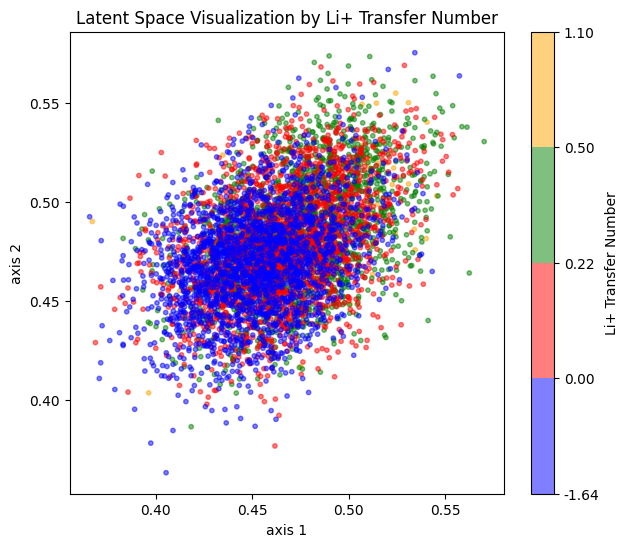

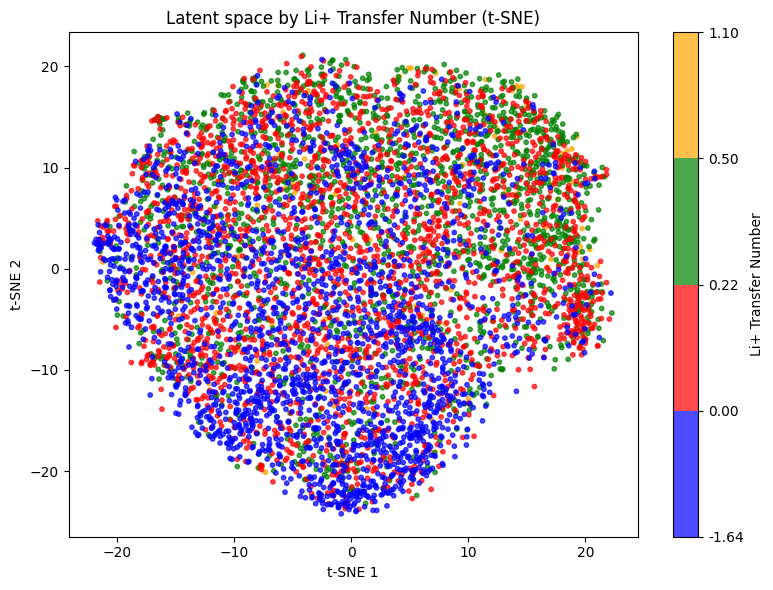

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from matplotlib.colors import ListedColormap
tsne = TSNE(n_components=2, perplexity=100, random_state=42, max_iter=2000)

X = z_tn.mean(dim=1).detach().cpu().numpy()
print(X.shape)
reduced = tsne.fit_transform(X)
# Step 1: 라벨 생성
labels_1 = np.repeat(np.array([0.5]), 113)
labels_2 = np.repeat(np.array([0.22]), 1829)
labels_3 = np.repeat(np.array([0.0]), 2209)
labels_4 = np.repeat(np.array([-1.0]), 2119)
labels = np.concatenate((labels_1, labels_2, labels_3, labels_4))

# Step 2: 임의 데이터 임베딩 (혹은 기존 reduced 사용)
# X = ... your features
# reduced = TSNE(...).fit_transform(X)
# 여기서는 reduced가 있다고 가정

# Step 3: 라벨 float → int class (0,1,2,3)
label_values = [-1.0, 0.0, 0.22, 0.5]  # 원하는 순서대로
def match_label(v, label_list):
    for i, val in enumerate(label_list):
        if np.isclose(v, val, atol=1e-3):
            return i
    return -1

int_labels = np.array([match_label(v, label_values) for v in labels])

# Step 4: 필터링
valid_mask = int_labels != -1
int_labels = int_labels[valid_mask]
reduced_valid = reduced[valid_mask]

# Step 5: 색상 설정
colors = ['blue', 'red', 'green', 'orange']
cmap = ListedColormap(colors)




# ------------------- latent space plot ------------------
plt.figure(figsize=(7, 6))
scat = plt.scatter(X[:, 0], X[:, 1], alpha=0.5, c=int_labels, cmap=cmap, s=10,  vmin=0, vmax=4)

cbar = plt.colorbar(scat, ticks=np.arange(5))
cbar.ax.set_yticklabels(["-1.64", "0.00",  "0.22", "0.50", "1.10"])
cbar.set_label("Li+ Transfer Number")

plt.title("Latent Space Visualization by Li+ Transfer Number")
plt.xlabel("axis 1")
plt.ylabel("axis 2")
plt.show()




# --------------------- latent space plot with T-SNE ------------
plt.figure(figsize=(8, 6))
scatter = plt.scatter(reduced_valid[:, 0], reduced_valid[:, 1], c=int_labels, cmap=cmap, s=10, alpha=0.7, vmin=0, vmax=4)



# Step 7: 컬러바 커스터마이징
cbar = plt.colorbar(scatter, ticks=np.arange(5))
cbar.ax.set_yticklabels(["-1.64", "0.00",  "0.22", "0.50", "1.10"])
cbar.set_label("Li+ Transfer Number")

plt.title("Latent space by Li+ Transfer Number (t-SNE)")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.tight_layout()
plt.show()


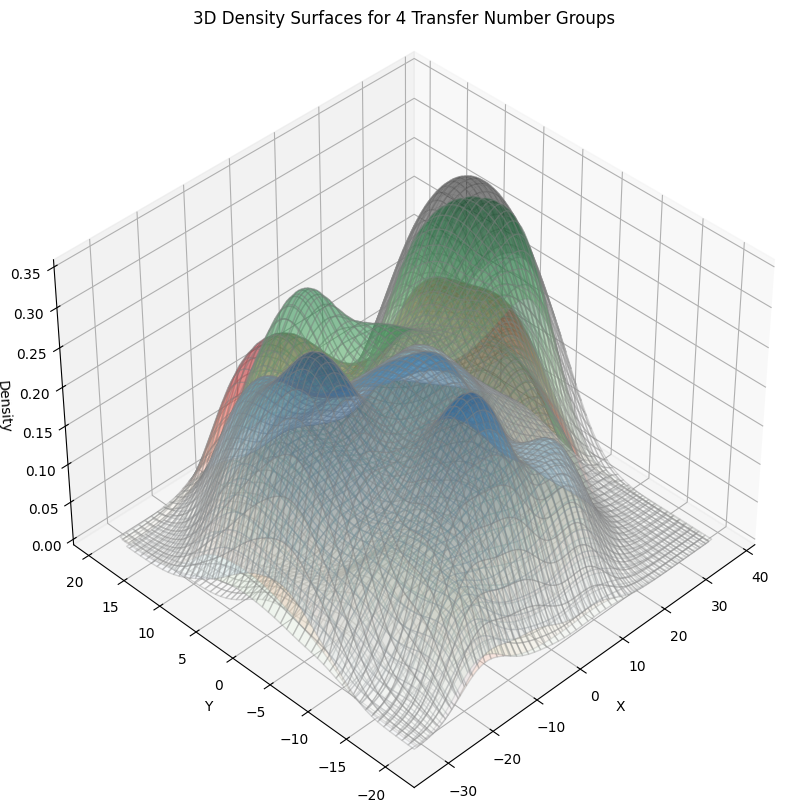

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import gaussian_kde

# 3D 플롯 그리기 위한 준비
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

z_tnn = split_data(reduced, [113, 1942, 4151])
groups = [z_tnn[0], z_tnn[1], z_tnn[2], z_tnn[3]]

# 각 그룹마다 밀도 함수 계산 및 서피스 플롯
colors = ['Greys', 'Greens', 'Reds', 'Blues']
for i, (data, cmap) in enumerate(zip(groups, colors)):
    # 각 그룹 데이터의 x, y 분리
    x = data[:, 0]
    y = data[:, 1]

    # KDE 계산 : 2차원 밀도 추정기 객체 생성
    values = np.vstack([x, y])
    kernel = gaussian_kde(values)
    
    # x, y 좌표 격자(grid) 생성
    x_min, x_max = x.min()-1, x.max()+1
    y_min, y_max = y.min()-1, y.max()+1
    xgrid = np.linspace(x_min, x_max, 100)
    ygrid = np.linspace(y_min, y_max, 100)
    X, Y = np.meshgrid(xgrid, ygrid)
    
    # 각 격자점에서 밀도 계산
    grid_coords = np.vstack([X.ravel(), Y.ravel()])
    Z = kernel(grid_coords)
    Z = Z.reshape(X.shape)
    Z = (1000 * Z)+1
    Z = np.log10(Z+1e-6)

    # 그룹별로 3D 서피스 플롯
    ax.plot_surface(X, Y, Z, cmap=cmap, alpha=0.3, edgecolor="grey")
    

# 3D 플롯 옵션 설정
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Density')
ax.set_title('3D Density Surfaces for 4 Transfer Number Groups')
ax.view_init(elev=40,azim=-135)
plt.show()

In [ ]:

os.environ["PYTORCH_ENABLE_FLASH_ATTENTION"] = "0"

import torch
torch.backends.cuda.enable_flash_sdp(False)
torch.backends.cuda.enable_mem_efficient_sdp(False)



# 이미 학습된 Transformer 기반 CVAE 모델을 불러왔다고 가정합니다.
# model.encoder와 model.decoder로 인코딩/디코딩이 가능

model.eval()


# 조건 정보 및 입력 문장의 형태에 맞게 설정 (예: 조건이 화학적 특성 벡터라면 해당 텐서)
condition = torch.tensor([0.65, 0.20588, 0.8489]).to(device)  # 조건 벡터, shape: [batch_size, condition_dim]

condition = model.input_embedding_p(condition.unsqueeze(-1))
condition = model.pos_enc(condition.unsqueeze(0))
# 입력 분자에 해당하는 데이터를 인코더에 넣어 latent 벡터 추출 (만약 재구성을 위해 사용했다면)
# X_input: 토큰 시퀀스로 표현한 분자. 만약 새롭게 생성하는 경우엔 인코더를 사용하지 않을 수도 있습니다.
# encoder_out = model.encoder(X_input, condition)
# mean, logvar = linear_layers(encoder_out)
# z = sample_using_reparameterization(mean, logvar)

# 생성 단계에서는 보통 prior(N(0,I))에서 직접 z를 샘플링하여 사용하거나
# 원하는 latent 공간의 특정 영역을 탐색할 수 있습니다.
latent_dim = 64  # latent 공간 차원
# 배치 내 한 개 혹은 여러 개 샘플 생성
torch.manual_seed(560)
z = torch.randn(1, 265, latent_dim).to(device)
#z = model.reparameterize(mean_tn[20], log_var_tn[100]).unsqueeze(0).permute(0, 2, 1)
print(z.shape)
zz = model.crossattn(z, condition, condition)
z_prime = model.ff(zz)


# 디코더의 autoregressive generate 함수 구현 (여기서는 간단한 greedy decoding 예시)
def generate_sequence(decoder, z, max_length=265, start_token=9, end_token=10,
                      fixed_seq_len=265, pad_token=166):
    """
    고정 시퀀스 길이 (fixed_seq_len)로 현재 시퀀스를 구성하여 디코더를 호출하는 생성 함수.
    
    Args:
        decoder: Transformer 디코더 (forward(current_sequence, z) 호출)
        z: latent vector, shape: [batch_size, seq_len, embedding_dim] 여기서는 [1, 265, 64]
        max_length: 최대 생성 길이 (예: 268)
        start_token: 시퀀스 시작 토큰
        end_token: 종료 토큰 (이 토큰이 생성되면 생성 종료)
        fixed_seq_len: 디코더에 넣을 고정 시퀀스 길이 (여기서는 265)
        pad_token: 패딩으로 사용할 토큰 (예시로 0)
    
    Returns:
        generated_tokens: 생성된 토큰 시퀀스 리스트
    """
    generated_tokens = [start_token]
    for _ in range(max_length):
        # 현재까지 생성된 토큰을 복사하여 고정 길이 시퀀스 구성
        current_seq = generated_tokens.copy()
        if len(current_seq) < fixed_seq_len:
            # 부족한 부분은 pad_token으로 채움
            current_seq += [pad_token] * (fixed_seq_len - len(current_seq))
        else:
            # 만약 generated_tokens가 fixed_seq_len보다 크다면 앞부분만 사용
            current_seq = current_seq[:fixed_seq_len]
        
        # current_seq의 shape: [1, fixed_seq_len]
        current_sequence = torch.tensor([current_seq]).to(device)
        print(current_sequence)
        with torch.no_grad():
            # 디코더의 forward 함수는 보통 current_sequence와 latent z를 입력받고,
            # output logits의 shape은 [batch_size, fixed_seq_len, vocab_size]를 반환한다고 가정
            logits = decoder(current_sequence, z)
            logits = model.predict(logits)
        
        # 예측할 위치는 현재까지 생성된 토큰 수와 동일함 
        # (예: 시작 토큰이 이미 있으므로, 첫 예측은 index= len(generated_tokens) == 1)
        pred_index = len(generated_tokens) if len(generated_tokens) < fixed_seq_len else fixed_seq_len - 1
        # logits[0, pred_index, :] 에서 가장 높은 확률의 토큰을 선택
        print(pred_index)
        next_token = torch.argmax(logits[0, pred_index-1, :]).item()

        generated_tokens.append(next_token)
                
        # 종료 토큰이 생성되면 break
        if next_token == end_token:
            break

    return generated_tokens

# 예시 호출 (z_prime는 shape [1, 265, 64]라고 가정)
generated_tokens = generate_sequence(model.decoder, z_prime,
                                     max_length=265, start_token=9, end_token=10)
print("Generated token sequence:", generated_tokens)


predicted_properties = model.pdecoder(condition, z_prime)
print(predicted_properties)

torch.Size([1, 265, 64])
tensor([[  9, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166,
         166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166,
         166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166,
         166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166,
         166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166,
         166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166,
         166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166,
         166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166,
         166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166,
         166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166,
         166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166,
         166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166,
         166, 166, 166, 166

RuntimeError: mat1 and mat2 shapes cannot be multiplied (265x256 and 64x128)

In [ ]:
dd = reverse_one_hot_encoding(torch.tensor(generated_tokens), dataset.vocab)
del dd[0]
del dd[-1]
print(dd)

ddd = atomInSmiles.decode(' '.join(dd))
print(ddd)
PS(ddd)

['[*;!R;N]', '[NH;!R;*C]', '[CH2;!R;CN]', '[CH2;!R;CN]', '[NH;!R;CC]', '[C;!R;*NO]', '(', '[*;!R;C]', ')', '=', '[O;!R;C]', ')', '[CH2;!R;CN]', '[NH;!R;CC]', '[CH2;!R;CN]', '[NH;!R;CC]', '[C;!R;*NO]', '(', '[*;!R;C]', ')', '=', '[O;!R;C]']
*NCCNC(*)=O)CNCNC(*)=O


AssertionError: PSMILES strings must have two [*], two *, [e] and [t], or [d] and [g] : *NCCNC(*)=O)CNCNC(*)=O